In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
import os
import numpy as np
import random
os.environ['TF_DETERMINISTIC_OPS'] ='1'
os.environ['TF_CUDNN_DETERMINISTIC']='1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
SEED=1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 資料準備

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_img_train,y_label_train),\
(x_img_test,y_label_test)=cifar10.load_data() 

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
y_label_train=y_label_train.reshape(-1)
y_label_test=y_label_test.reshape(-1)

In [ ]:
x_img_train_normalize=x_img_train.astype('float32')/255.0
x_img_test_normalize=x_img_test.astype('float32')/255.0

In [ ]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_label_train)
y_test_onehot = utils.to_categorical(y_label_test)

In [ ]:
print("train data:",'images:',x_img_train.shape,
   "labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ,
   " labels:",y_label_test.shape) 

In [ ]:
from sklearn.model_selection import train_test_split
x_img_train_normalize,x_img_val_normalize,y_train_onehot,y_val_onehot=\
         train_test_split(
             x_img_train_normalize,
             y_train_onehot, 
             test_size=0.2, 
             random_state=888)

In [ ]:
print("train data:",'images:',x_img_train_normalize.shape,
   " labels:",y_train_onehot.shape) 
print("val data:",'images:',x_img_val_normalize.shape,
   " labels:",y_val_onehot.shape) 
print("test  data:",'images:',x_img_test_normalize.shape ,
   " labels:",y_test_onehot.shape) 

train data: images: (40000, 32, 32, 3)  labels: (40000, 10)
val data: images: (10000, 32, 32, 3)  labels: (10000, 10)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 10)


# 建立模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dropout, MaxPooling2D
from tensorflow.keras.layers import Dense,Activation,Flatten

In [ ]:
def block(p_bname,p_filters,p_conv,p_drop_rate):
  for i in range(p_conv):
    model.add(Conv2D(filters=p_filters,kernel_size=(3,3),
             activation='relu',padding='same',
             name=p_bname+'_conv'+str(i)))
  model.add(MaxPooling2D(pool_size=(2, 2),name=p_bname+'_pool'))
  if p_drop_rate>0: model.add(Dropout(drop_rate,name=p_bname+'_Dr'))  

In [ ]:
drop_rate=0
model = Sequential()
model.add(Input(shape=(32, 32,3)))
block(p_bname='B1',p_filters=32,p_conv=2,
   p_drop_rate=drop_rate)
block(p_bname='B2',p_filters=64,p_conv=2,
   p_drop_rate=drop_rate)
block(p_bname='B3',p_filters=128,p_conv=2,
   p_drop_rate=drop_rate)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 B1_conv0 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 B1_conv1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_pool (MaxPooling2D)      (None, 16, 16, 32)        0         
                                                                 
 B2_conv0 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 B2_conv1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 B2_pool (MaxPooling2D)      (None, 8, 8, 64)          0         
                                                                 
 B3_conv0 (Conv2D)           (None, 8, 8, 128)         7

# 訓練模型

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=15)

In [ ]:
!mkdir Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="Model/Cifar_C345P1_DrBnErAu.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
BATCH_SIZE=200

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,horizontal_flip=True,
    width_shift_range=0.2,height_shift_range=0.2,
    zoom_range=0.2  )

In [ ]:
BATCH_SIZE=200

In [ ]:
train_history=model.fit(
  datagen.flow(x=x_img_train_normalize,
         y=y_train_onehot,
         batch_size=BATCH_SIZE),
  steps_per_epoch = len(x_img_train_normalize) / BATCH_SIZE, 
  validation_data=(x_img_val_normalize, y_val_onehot),
  epochs=200,callbacks=[early_stopping,checkpoint]) 

Epoch 1/200
200/200 [==============================] - ETA: 0s - loss: 1.9072 - acc: 0.2893
Epoch 00001: val_acc improved from -inf to 0.42790, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 31s 114ms/step - loss: 1.9072 - acc: 0.2893 - val_loss: 1.5524 - val_acc: 0.4279
Epoch 2/200
200/200 [==============================] - ETA: 0s - loss: 1.6113 - acc: 0.4076
Epoch 00002: val_acc improved from 0.42790 to 0.49630, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 20s 101ms/step - loss: 1.6113 - acc: 0.4076 - val_loss: 1.4023 - val_acc: 0.4963
Epoch 3/200
200/200 [==============================] - ETA: 0s - loss: 1.4662 - acc: 0.4675
Epoch 00003: val_acc improved from 0.49630 to 0.51990, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 20s 101ms/step - loss: 1.4662 - acc: 0.4675 - val_loss: 1.3549 - val_acc: 0.5199
Epoch 4/200
200/200 [============================

In [ ]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

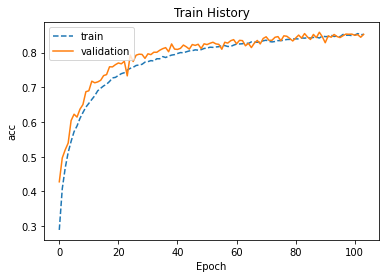

In [ ]:
show_train_history(train_history,'acc','val_acc')

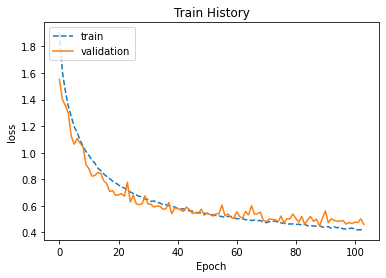

In [ ]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)

313/313 [==============================] - 1s 3ms/step - loss: 0.4810 - acc: 0.8463


In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.4809737801551819 test_acc= 0.8463000059127808


# 載入最佳模型

In [ ]:
model.load_weights(filepath)

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)
scores[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.4785 - acc: 0.8500


0.8500000238418579

In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.4784664511680603 test_acc= 0.8500000238418579


# 進行預測

In [ ]:
probability=model.predict(x_img_test_normalize)

In [ ]:
prediction=tf.argmax(probability, axis=-1).numpy()

In [ ]:
prediction[:10]

array([3, 8, 8, 8, 6, 6, 1, 6, 4, 1])

# 查看預測結果

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
      5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [ ]:
def plot_images_labels_prediction(
    images,labels,prediction,idx,num=10):
    fig = plt.gcf().set_size_inches(12, 12)    
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= str(idx)+',' +label_dict[labels[idx]]
        if len(prediction)>0:
            title+="=>"+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

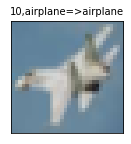

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=1)

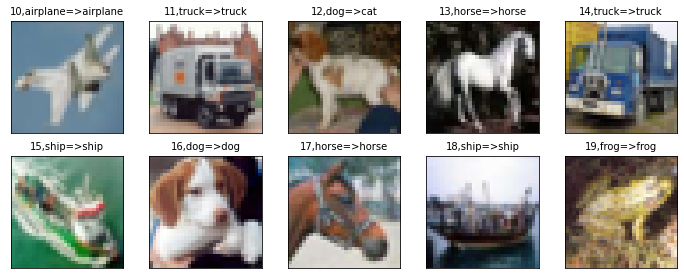

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=10)

# 查看預測機率

In [ ]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary')
  plt.show()
  print('label:',label_dict[labels[idx]],
        'predict:',label_dict[prediction[idx]]) 
  for i in range(10):
    print('%-10s Probability:%.9f'%(label_dict[i],probability[idx][i]))      

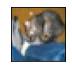

label: cat predict: cat
airplane   Probability:0.000410795
automobile Probability:0.074348606
bird       Probability:0.000945019
cat        Probability:0.841776967
deer       Probability:0.000512376
dog        Probability:0.041730493
frog       Probability:0.031466685
horse      Probability:0.000405815
ship       Probability:0.001838460
truck      Probability:0.006564862


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,0) 

# confusion matrix

In [ ]:
import pandas as pd

In [ ]:
pd.crosstab(y_label_test,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,859,12,26,4,9,2,6,12,35,35
1,6,925,1,0,0,0,0,3,9,56
2,43,4,767,21,39,43,47,18,4,14
3,12,7,35,695,34,105,46,22,14,30
4,3,0,28,31,834,19,40,27,5,13
5,8,1,14,72,31,801,17,26,2,28
6,7,4,15,14,14,5,921,3,5,12
7,10,2,12,14,25,19,6,897,1,14
8,53,21,3,5,1,1,2,2,874,38


In [ ]:
df = pd.DataFrame({'label':y_label_test, 'predict':prediction})

In [ ]:
df[:5]

,label,predict
0,3,3
1,8,8
2,8,8
3,0,8
4,6,6


In [ ]:
df[(df.label==5)&(df.predict==3)]

,label,predict
12,5,3
155,5,3
275,5,3
551,5,3
640,5,3
...,...,...
9380,5,3
9414,5,3
9616,5,3
9661,5,3


# 查看預測錯誤資料

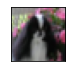

label: dog predict: dog
airplane   Probability:0.004033607
automobile Probability:0.005024752
bird       Probability:0.010609505
cat        Probability:0.191579074
deer       Probability:0.013077625
dog        Probability:0.574686527
frog       Probability:0.001096651
horse      Probability:0.051319506
ship       Probability:0.000113015
truck      Probability:0.148459747


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,42)

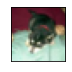

label: dog predict: frog
airplane   Probability:0.004238627
automobile Probability:0.000357124
bird       Probability:0.003933955
cat        Probability:0.216699883
deer       Probability:0.025773922
dog        Probability:0.039833046
frog       Probability:0.652695596
horse      Probability:0.042731669
ship       Probability:0.000156803
truck      Probability:0.013579461


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,128)